In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision.models import vit_b_16
import torchvision.models.vision_transformer as vit
import torch.optim as optim

import matplotlib.pyplot as plt

from tqdm import tqdm

import os

from torch.utils.data import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler, RandomSampler

import numpy as np
from google.colab import drive

from dataclasses import dataclass

import random

from sklearn.utils.class_weight import compute_class_weight

## Hyper-parameters for ViT

In [ ]:
num_classes = 7
patch_size = 16
image_size = 224

# tunable hyperparameter:
dropout = 0.1
attention_dropout = 0.1
bs = 64
lr = 0.001
weight_decay = 0.1
betas = (0.9,0.999)
epoch = 15


# Dataset and Data loader

In [ ]:
import torch
from PIL import Image
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import os
import cv2

import numpy as np

import pandas as pd

In [ ]:
drive.mount('/content/drive')
config = dict()
config['metadata_dir'] = '/content/drive/My Drive/Dataset/HAM10000/HAM10000_metadata.csv'
config['image_data_dir'] = '/content/drive/My Drive/Dataset/image_frame/'
config['save_data_dir'] = '/content/drive/My Drive/Dataset/save_data/'

config['train_data_dir'] = '/content/drive/My Drive/Dataset/HAM10000/data/HAM10000_images_part_2'
config['valid_data_dir'] = '/content/drive/My Drive/Dataset/HAM10000/data/HAM10000_images_part_1'

# configs:
saved_model_name = "vit_model_frozen_weight+oversample_epoch{}_lr{}.pt".format(epoch, lr)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define the image transform module.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
    ])

## Define Customed Dataset

In [ ]:
class VitDataset(Dataset):
  """
  A Dataset Loader design for Vision Transformer under PyTorch.
  """  

  def __init__(self, image_dir, label_data_dir, transform=None):

    self.img_dir = image_dir
    self.label_data_dir = label_data_dir
    self.transforms = transform

    # list that store the name of all images
    self.image_path = os.listdir(image_dir)

    # match the image name with its label:
    self.label_to_num = self._label_transformer()
    self.img_to_label = self._label_image_matcher()

    # filter out unknown images:
    self.all_imgs = []
    for filename in self.image_path:
      img_name = filename.split('.')[0]
      if img_name in self.img_to_label:
        self.all_imgs.append(filename)

  def _label_transformer(self):
    """Transform lesion name (bkl ...) to a integer."""
    train_metadata = pd.read_csv(self.label_data_dir)
    raw_lesion_name = train_metadata['dx']
    processed_name = dict()
    count = 0
    for lesion in raw_lesion_name:
      if lesion not in processed_name:
        processed_name[lesion] = count
        count += 1
    return processed_name


  def _label_image_matcher(self):
    """
    Match each image with its label.

    {'img_011': 0, 'img_012': 2, .....}
    """
    train_metadata = pd.read_csv(self.label_data_dir)
    image_ids = list(train_metadata['image_id'])
    lesion_ids = list(train_metadata['dx'])

    assert len(image_ids) == len(lesion_ids)

    finder = dict()

    for i in range(len(image_ids)):
      if image_ids[i] in finder:
        raise Exception('Duplicate Image Exists !')
      finder[image_ids[i]] = self.label_to_num[lesion_ids[i]]

    return finder


  def __len__(self):
    return len(self.all_imgs)


  def __getitem__(self, index):

    total_num = self.__len__()

    assert index < total_num

    img_name = self.all_imgs[index]

    image_dir = os.path.join(self.img_dir, img_name)

    image = Image.open(image_dir)

    label = self.img_to_label[img_name.split('.')[0]]

    if self.transforms is not None:
      image = self.transforms(image)

    return image, label

  def _split_train_valid(self, train_portion):
      """
      Split the data into: 
        - train_portion% of training
        - (1-train_portion) of validation
      """
      assert train_portion < 1

      temp_imgID_leision_finder = self._label_image_matcher()
      
      full_info = {0: [], 1: [], 2:[], 3: [], 4: [], 5: [], 6: []}

      train_image_idx = []
      valid_image_idx = []

      for image_id in temp_imgID_leision_finder:

        lesion = temp_imgID_leision_finder[image_id]
        
        full_info[lesion].append(image_id)


      for lesion in full_info:

        lesion_images = full_info[lesion]

        full_len = len(lesion_images)
        train_len = int(np.floor(train_portion * full_len))

        train_image_idx += lesion_images[0:train_len + 1]
        valid_image_idx += lesion_images[train_len + 1:]

        assert len(lesion_images[0:train_len + 1]) + \
        len(lesion_images[train_len + 1:]) == full_len

      random.shuffle(train_image_idx)
      random.shuffle(valid_image_idx)

      return train_image_idx, valid_image_idx

  def get_label(self, index):
    
    total_num = self.__len__()
    assert index < total_num

    img_name = self.all_imgs[index]
    label = self.img_to_label[img_name.split('.')[0]]
    return label

  def get_all_labels(self):
    all_labels = []
    for img_name in self.all_imgs:
      label = self.img_to_label[img_name.split('.')[0]]
      all_labels.append(label)
    return np.array(all_labels)


## Split training and validation data

In [ ]:
all_data = VitDataset(config['image_data_dir'], config['metadata_dir'], transform)
training_data, validation_data = torch.utils.data.random_split(all_data, [0.85, 0.15])

In [ ]:
print(len(training_data))
print(len(validation_data))

8513
1502


# ViT Model Structure

In [ ]:
class SkinCancerViT(nn.Module):
  def __init__(
      self,
      num_classes: int,
      image_size=image_size,
      patch_size=patch_size,
      ):
    super().__init__()
    self.image_size = image_size
    self.patch_size = patch_size

    self.pretrained_model = vit_b_16(weights=vit.ViT_B_16_Weights.IMAGENET1K_V1, dropout=dropout, attention_dropout=attention_dropout)

    self.heads = nn.Sequential(
        nn.Linear(self.pretrained_model.hidden_dim, num_classes),
    )
    
    # freezing ImageNet pre-trained weights
    for param in self.pretrained_model.parameters():
      param.requires_grad = False

  def _process_input(self, x):
    x = self.pretrained_model._process_input(x)
    return x

  def forward(self, x):
    # Reshape and permute the input tensor
    x = self._process_input(x)
    n = x.shape[0]

    # Expand the class token to the full batch
    batch_class_token = self.pretrained_model.class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)

    x = self.pretrained_model.encoder(x)

    # Classifier "token" as used by standard language architectures
    x = x[:, 0]

    x = self.heads(x)
    
    return x



In [ ]:
vit_model = SkinCancerViT(num_classes)

# Training ViT

## Training Loop

In [ ]:
class FocalLoss(nn.Module):
  def __init__(self, alpha, gamma, weights=None, reduction='mean'):
    super(FocalLoss, self).__init__()
    self.alpha = alpha
    self.gamma = gamma
    self.reduction = reduction
    self.weights = weights

  def forward(self, inputs, targets):
    ce_loss = F.cross_entropy(inputs, targets, reduction='none')
    pt = torch.exp(-ce_loss)

    focal_loss = self.alpha * (1 - pt) ** (self.gamma) * ce_loss

    if self.reduction == 'mean':
      return focal_loss.mean(dim=-1)
    elif self.reduction == 'sum':
      return focal_loss.sum(dim=-1)
    else:
      return focal_loss

In [ ]:
def train(model, trainloader, validation_data, weight=None):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("Training on {}".format(device))

  # criterion = torch.nn.CrossEntropyLoss(weight=weight).to(device)
  criterion = FocalLoss(alpha=0.25, gamma=2, weights=weight)
  optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

  model.to(device)
  train_losses = []
  valid_losses = []
  train_accs = []
  valid_accs = []

  cur_best_acc = 0
  for ep in range(epoch):
    model.train()
    train_loss = 0
    acc_train = 0
    train_total = 0
    for (img, label) in tqdm(trainloader):
      img = img.to(device)
      label = label.to(device)

      optimizer.zero_grad()
      
      logits = model(img)
      # print("\n")
      # print(logits)
      # print(label)

      loss = criterion(logits, label)
      loss.backward()
      optimizer.step()

      # calculate training accuracy/loss
      batch_size = img.shape[0]
      train_loss += loss.item() * batch_size
      pred_train = torch.argmax(logits, dim=1).squeeze()
      acc_train += (pred_train == label).sum()
      train_total += batch_size

    # add training loss/acc
    train_loss = (train_loss/train_total)
    acc_train = (acc_train/train_total).cpu()
    train_losses.append(train_loss)
    train_accs.append(acc_train)

    with torch.no_grad():
      model.eval()
      valid_loss = 0
      acc_valid = 0
      valid_total = 0
      for (img, label) in tqdm(validation_data):
        img = img.to(device)
        label = label.to(device)
        logits = model(img)
        batch_size = img.shape[0]

        # calculate validation accuracy/loss
        valid_total += batch_size
        valid_loss += criterion(logits, label).item()*batch_size
        pred_valid = torch.argmax(logits, dim=1).squeeze()
        acc_valid += (pred_valid == label).sum()
        

      # add validation loss
      valid_loss = (valid_loss/valid_total)
      acc_valid = (acc_valid/valid_total).cpu()
      valid_losses.append(valid_loss)
      valid_accs.append(acc_valid)

      print(("Epoch {}: Training Loss {}; Validation Loss: {};\n" 
            + "Training Accuracy: {}; Validation Accuracy: {}").format(
                                                            ep+1, 
                                                            train_loss,
                                                            valid_loss,
                                                            acc_train,
                                                            acc_valid
                                                            ))
      # save the model with lowest validation loss
      if acc_valid > cur_best_acc:
        torch.save(model.state_dict(), config['save_data_dir'] + saved_model_name)
        print("Current model weights saved.")
        cur_best_acc = acc_valid


  return train_losses, valid_losses, train_accs, valid_accs

## Calculate class weights to deal with class imbalance

In [ ]:
all_labels = None
for _, label in tqdm(DataLoader(training_data, batch_size=bs)):
  if all_labels is None:
    all_labels = label
  else:
    all_labels = torch.cat((all_labels, label), dim=0)
print(all_labels.shape)
print(all_labels)

100%|██████████| 134/134 [02:06<00:00,  1.06it/s]

torch.Size([8513])
tensor([1, 1, 1,  ..., 1, 0, 1])


In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels.numpy())
class_weights = torch.tensor(class_weights).float()
class_weights

tensor([ 1.2951,  0.2134, 11.5823,  1.2965, 10.4840,  2.8022,  4.3279])

## Oversampler to deal with class imbalance

In [ ]:
sample_weights = class_weights[all_labels]
oversampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# oversampler = RandomSampler(training_data)

## Run the training loop

In [ ]:
train_losses, valid_losses, train_accs, valid_accs = train(vit_model,
                                                            DataLoader(training_data, batch_size=bs, sampler=oversampler),
                                                            DataLoader(validation_data, batch_size=bs),
                                                           weight=class_weights)


Training on cuda


100%|██████████| 24/24 [00:36<00:00,  1.50s/it]


Epoch 1: Training Loss 0.2815956784086034; Validation Loss: 0.2810780453618452;
Training Accuracy: 0.385528028011322; Validation Accuracy: 0.22902795672416687
Current model weights saved.


100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


Epoch 2: Training Loss 0.25869326787956676; Validation Loss: 0.2771920608220183;
Training Accuracy: 0.4370962083339691; Validation Accuracy: 0.27962714433670044
Current model weights saved.


100%|██████████| 24/24 [00:35<00:00,  1.50s/it]


Epoch 3: Training Loss 0.258639880097964; Validation Loss: 0.24000328330796822;
Training Accuracy: 0.4361564815044403; Validation Accuracy: 0.31557920575141907
Current model weights saved.


100%|██████████| 24/24 [00:36<00:00,  1.50s/it]


Epoch 4: Training Loss 0.26038851934406043; Validation Loss: 0.2199317916890435;
Training Accuracy: 0.43932807445526123; Validation Accuracy: 0.40213048458099365
Current model weights saved.


100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


Epoch 5: Training Loss 0.2572103750915067; Validation Loss: 0.21061011353202572;
Training Accuracy: 0.4376835525035858; Validation Accuracy: 0.49667108058929443
Current model weights saved.


100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


Epoch 6: Training Loss 0.2601919421771012; Validation Loss: 0.21678484738190545;
Training Accuracy: 0.4347468614578247; Validation Accuracy: 0.42343538999557495


100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


Epoch 7: Training Loss 0.26077557838538634; Validation Loss: 0.24358607513133124;
Training Accuracy: 0.431105375289917; Validation Accuracy: 0.33288946747779846


100%|██████████| 24/24 [00:36<00:00,  1.50s/it]


Epoch 8: Training Loss 0.2598000935003254; Validation Loss: 0.2312577447386461;
Training Accuracy: 0.4296957552433014; Validation Accuracy: 0.378828227519989


100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


Epoch 9: Training Loss 0.25826515153559787; Validation Loss: 0.23688566077565068;
Training Accuracy: 0.44214731454849243; Validation Accuracy: 0.368175745010376


100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


Epoch 10: Training Loss 0.2589820036663511; Validation Loss: 0.24006817820227733;
Training Accuracy: 0.4378010034561157; Validation Accuracy: 0.35419440269470215


100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


Epoch 11: Training Loss 0.2601748472422057; Validation Loss: 0.22291894501122272;
Training Accuracy: 0.4264066815376282; Validation Accuracy: 0.3688415288925171


100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


Epoch 12: Training Loss 0.26062505133953273; Validation Loss: 0.2262349620798774;
Training Accuracy: 0.4316927194595337; Validation Accuracy: 0.4354194104671478


100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


Epoch 13: Training Loss 0.2627472781825539; Validation Loss: 0.27712212465257047;
Training Accuracy: 0.41747915744781494; Validation Accuracy: 0.24900132417678833


100%|██████████| 24/24 [00:36<00:00,  1.50s/it]


Epoch 14: Training Loss 0.25905679815015487; Validation Loss: 0.27216967269679043;
Training Accuracy: 0.4313403069972992; Validation Accuracy: 0.2476697564125061


100%|██████████| 24/24 [00:36<00:00,  1.50s/it]

Epoch 15: Training Loss 0.2570481872612506; Validation Loss: 0.2307037517091088;
Training Accuracy: 0.44531893730163574; Validation Accuracy: 0.3701730966567993


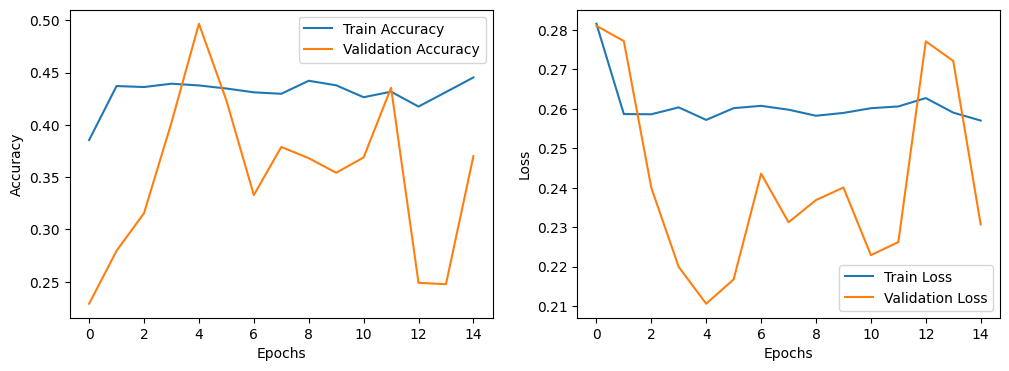

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluating ViT

In [ ]:
def test(model, testloader):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print("Testing on {}".format(device))

  model.to(device)
  model.eval()

  result = None
  ground = None
  scores = None
  with torch.no_grad():
    for (img, truth) in tqdm(testloader):
      img = img.to(device)
      logit = model(img)
      prediction = torch.argmax(logit, dim=1)

      if result is None:
        result = prediction
      else:
        result = torch.cat((result, prediction),dim=0)
      
      if ground is None:
        ground = truth
      else:
        ground = torch.cat((ground, truth),dim=0)

      normal_logit = torch.softmax(logit, dim=1)
      if scores is None:
        scores = normal_logit
      else:
        scores = torch.cat((scores, normal_logit),dim=0)

  
  return scores.cpu(), result.cpu(), ground

## Test data

In [ ]:
class VitTestDataset(VitDataset):
  def __init__(self, image_dir, label_data_dir, test_truth_dir, transform=None):
    self.test_truth_dir = test_truth_dir
    super().__init__(image_dir, label_data_dir, transform)

  def _label_image_matcher(self):
    
    test_metadata = pd.read_csv(self.test_truth_dir)
    image_ids = list(test_metadata['image'])

    lesion_ids = [None] * len(image_ids)


    # lesion_ids = list(test_metadata['dx'])

    assert len(image_ids) == len(lesion_ids)

    finder = dict()

    for i in range(len(image_ids)):
      if image_ids[i] in finder:
        raise Exception('Duplicate Image Exists !')
      for disease, disease_id in self.label_to_num.items():
        column = list(test_metadata[disease.upper()])
        # print(column)
        if column[i] == 1:
          finder[image_ids[i]] = disease_id
          break

    return finder


In [ ]:
config['test_data_dir'] = '/content/drive/My Drive/Dataset/test_data/data/'
config['test_truth_dir'] = '/content/drive/My Drive/Dataset/test_data/ISIC2018_Task3_Test_GroundTruth.csv'

test_data = VitTestDataset(config['test_data_dir'], config['metadata_dir'], config['test_truth_dir'], transform)

## Run test loop

In [ ]:
# test_data = validation_data
# test_data = training_data

saved_weight = config['save_data_dir'] + saved_model_name
vit_model.load_state_dict(torch.load(saved_weight))

scores, result, ground_truth = test(vit_model,
              DataLoader(test_data, batch_size=bs))
print(result)

Testing on cuda


100%|██████████| 24/24 [01:50<00:00,  4.59s/it]


tensor([3, 3, 4,  ..., 3, 3, 3])


## Class-level Testing Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, ConfusionMatrixDisplay, roc_auc_score
import seaborn as sns

In [ ]:
num_to_lab = test_data.label_to_num
print(num_to_lab)

{'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'vasc': 4, 'bcc': 5, 'akiec': 6}


### Accuracy

In [ ]:
((result == ground_truth).sum() / len(result)).item()

0.46362432837486267

### Confusion Matrix

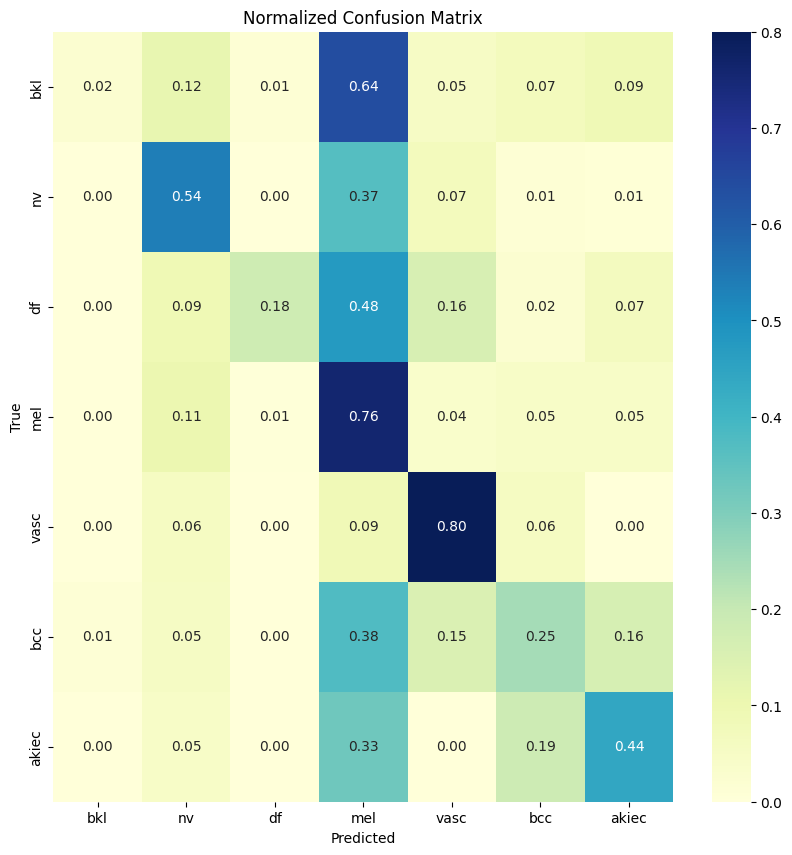

In [ ]:
conf = confusion_matrix(ground_truth, result)
# normalize confusion matrix
conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
sns.heatmap(conf, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=num_to_lab.keys(), yticklabels=num_to_lab.keys())
# ConfusionMatrixDisplay(conf, display_labels=num_to_lab).plot()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

## Two-way Accuracy

In [ ]:
malignant = ['akiec', 'bcc', 'mel']
mal_idx = []
benign_idx = []
for disease, idx in num_to_lab.items():
  if disease in malignant:
    mal_idx.append(idx)
  else:
    benign_idx.append(idx)

In [ ]:
def plot_auc_roc_curve(ground_truth, scores, title):
  
  # get score of benign vs. malignant
  benign_score = scores[:, benign_idx].sum(dim=1).squeeze()
  mal_score = scores[:, mal_idx].sum(dim=1).squeeze()
  # get ground truth for test data
  binary_truth = torch.zeros_like(ground_truth)
  for i in range(ground_truth.shape[0]):
    if ground_truth[i].item() in mal_idx:
      binary_truth[i] = 1

  fpr, tpr, thresholds = roc_curve(binary_truth, mal_score, pos_label=1)
  sensitivity = tpr
  specificity = 1 - fpr

  auc_score = roc_auc_score(binary_truth, mal_score)

  plt.plot(sensitivity, specificity)
  plt.xlabel("Sensitivity")
  plt.ylabel("Specificity")
  plt.title(title)
  plt.text(0.5, 0.3, f"AUC score: {auc_score:.2f}", ha='center', va='center', bbox=dict(facecolor='white', edgecolor='gray', pad=5.0))
  plt.show()

  print("AUC score is "+ str(auc_score))

  binary_pred = torch.zeros_like(binary_truth)
  binary_pred[mal_score >= 0.5] = 1
  binary_acc = ((binary_pred == binary_truth).sum() / len(binary_truth)).item()
  print("Two-way accuracy is " + str(binary_acc))

### Benign vs. Malignant (All samples)

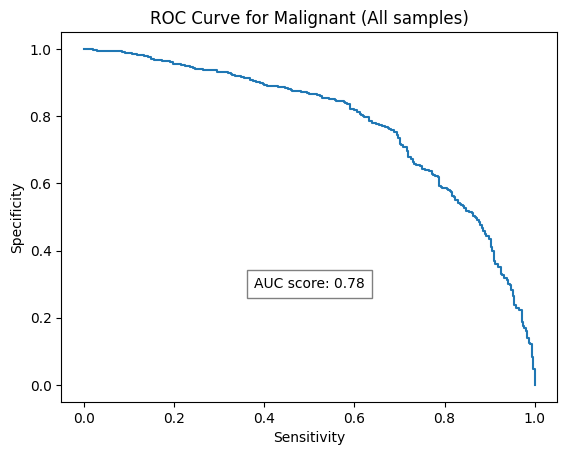

AUC score is 0.7771013826753348
Two-way accuracy is 0.75


In [ ]:
plot_auc_roc_curve(ground_truth, scores, "ROC Curve for Malignant (All samples)")

### Melanoma (nv (benign) vs. mel (malignant))

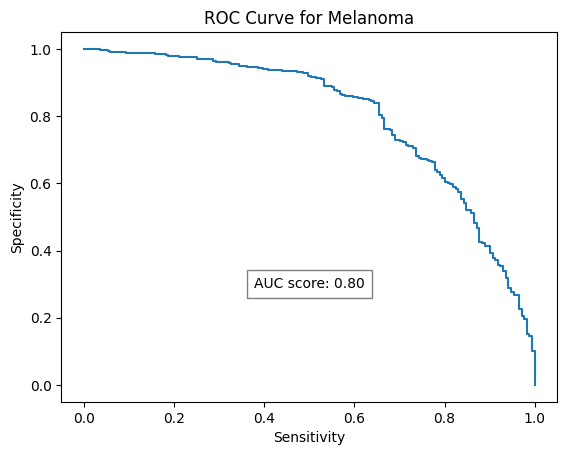

AUC score is 0.800757853563134
Two-way accuracy is 0.8166666626930237


In [ ]:
mel_nv_indices = np.where((ground_truth == num_to_lab['mel']) | (ground_truth == num_to_lab['nv']))
melanoma_true_filtered = ground_truth[mel_nv_indices]
melanoma_score_filtered = scores[mel_nv_indices]

plot_auc_roc_curve(melanoma_true_filtered, melanoma_score_filtered, "ROC Curve for Melanoma")

### Carcinoma (bkl (benign) vs. akiec&bcc (malignant)) 

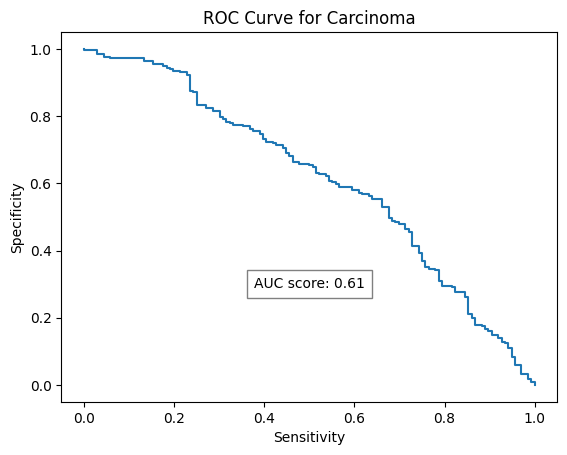

AUC score is 0.6142247221469233
Two-way accuracy is 0.5524079203605652


In [ ]:
carcinoma_indices = np.where((ground_truth == num_to_lab['bkl']) |
                             (ground_truth == num_to_lab['akiec']) |
                             (ground_truth == num_to_lab['bcc']))
carcinoma_true_filtered = ground_truth[carcinoma_indices]
carcinoma_score_filtered = scores[carcinoma_indices]

plot_auc_roc_curve(carcinoma_true_filtered, carcinoma_score_filtered, "ROC Curve for Carcinoma")